In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
# load memory_saving_gradients.py
# see https://github.com/cybertronai/gradient-checkpointing
import urllib.request
memSavingGradientsFilename = "memory_saving_gradients.py"
if not os.path.exists(memSavingGradientsFilename):
    memSavingGradientsURL = "https://raw.githubusercontent.com/cybertronai/gradient-checkpointing/master/memory_saving_gradients.py"
    urllib.request.urlretrieve(memSavingGradientsURL, memSavingGradientsFilename)
    
    from memory_saving_gradients import gradients
    tf.__dict__["gradients"] = memory_saving_gradients.gradients_collection

In [3]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.training as cft
import claude.claudeflow.helper as cfh
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.models.SSFstatic as ssf

In [4]:
# True:  runs on cluster with GPU etc
# False: can run localy
runWithNonlinear = False

In [5]:
# Tx
param = cfs.defaultParameters(precision='double')

if runWithNonlinear:    
    param.sps = 16
    param.nSamples = 2048
    param.optimizeP = True
    param.PdBm  = -1
else:    
    param.sps = 16
    param.nSamples = 1024
    param.PdBm  = 0
    
param.M     = 16
param.Fs    = param.sps * param.Rs
print(param)

M:	16
nPol:	2
sps:	16
nSamples:	1024
rollOff:	0.05
filterSpan:	128
optimizeP:	False
PdBm:	0
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
frequencyShift:	True
dispersionCompensation:	False
beta2:	2.0999953937404486e-26
dz:	1000000.0
Fs:	512000000000.0
N:	16384
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>



In [6]:
ssfParam = ssf.defaultParameters(precision='double')
ssfParam.Fs = param.Fs
ssfParam.N = param.sps * param.nSamples
ssfParam.noiseEnabled = True
ssfParam.noiseFigure = 5
ssfParam.nSpans = 10

if runWithNonlinear:
    ssfParam.gamma = 1
    ssfParam.nSteps = 1000
else:
    ssfParam.gamma = 0
    ssfParam.nSteps = 2

ssfParam.stepSize = ssfParam.spanLength/ssfParam.nSteps
ssfParam.stepSizeTemplate = ssfParam.stepSize * np.ones((ssfParam.nSteps,)) # constant stepsize

# ssfParam.stepSizeTemplate = ssf.logStepSizes(ssfParam.spanLength, ssfParam.alpha, ssfParam.nSteps) # log stepsize

print(ssfParam)

Fs:	512000000000.0
N:	16384
nSteps:	2
stepSize:	50.0
ampScheme:	EDFA
noiseEnabled:	True
manakovEnabled:	True
dispersionCompensationEnabled:	False
checkpointInverval:	2
nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	0
nSpans:	10
spanLength:	100
noiseFigure:	5
intType:	<dtype: 'int32'>
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
stepSizeTemplate:	[50. 50.]



In [7]:
aeParam = cu.AttrDict()
aeParam.seed    = 1337
aeParam.constellationOrder = param.M
aeParam.constellationDim = 2

if runWithNonlinear:
    aeParam.nLayers = 4
    aeParam.nHidden = 64
else:
    aeParam.nLayers = 2
    aeParam.nHidden = 32

aeParam.activation = tf.nn.relu

print(aeParam)

seed:	1337
constellationOrder:	16
constellationDim:	2
nLayers:	2
nHidden:	32
activation:	<function relu at 0x7fb5bdc13730>



In [8]:
trainingParam = cu.AttrDict()
if runWithNonlinear:    
    trainingParam.batchSize     = 1
    trainingParam.nBatches      = 4
    trainingParam.nMiniBatches  = 4
    trainingParam.removeSymbols = 128
else:    
    trainingParam.batchSize     = 1
    trainingParam.nBatches      = 1
    trainingParam.nMiniBatches  = 4
    trainingParam.removeSymbols = 32
    
trainingParam.nEpochs             = 50

trainingParam.learningRate        = 1e-2
trainingParam.displayStep         = 1
trainingParam.path                = 'results_SSFM'
trainingParam.filename            = 'M{:03d}_seed{:04d}'.format(param.M,aeParam.seed)
trainingParam.earlyStopping       = 25
trainingParam.earlyStoppingMetric = 'xentropy'
trainingParam.summaries           = True

# generalize this
if trainingParam.summaries:
    # tensorboard directory
    hyperParam = ['M']
    aeHyperParam = ['seed']
    trainingHyperParam = ['learningRate']

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,param[item]) for item in hyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)
    
print(trainingParam)

M=16,learningRate=0.01,seed=1337
batchSize:	1
nBatches:	1
nMiniBatches:	4
removeSymbols:	32
nEpochs:	5
learningRate:	0.01
displayStep:	1
path:	results_SSFM
filename:	M016_seed1337
earlyStopping:	25
earlyStoppingMetric:	xentropy
summaries:	True
summaryString:	M=16,learningRate=0.01,seed=1337



In [9]:
# Constants
c = 299792458
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

In [10]:
X = tf.placeholder(param.realType, shape=(None, param.nChannels, param.nPol, param.nSamples, param.M))
txSymbols, constellation = ae.encoder(X, aeParam, toComplex=True)

W0907 10:08:48.885838 140419643709248 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
signal = cfs.wdmTransmitter(txSymbols, param)

ssfParam.stepSize = tf.placeholder(param.realType, shape=(ssfParam.nSpans, ssfParam.nSteps))
signalOut = ssf.model(ssfParam, signal)

param.dispersionCompensation = True
param.beta2  = ssfParam.D * 1e-6 * ( c / ssfParam.Fc )**2 / ( 2 * np.pi * c )
param.dz     = ssfParam.spanLength * 1e3 * ssfParam.nSpans
rxSymbols = cfs.wdmReceiver(signalOut, param)

nSpans: 10, nSteps: 2


In [13]:
rxSymbols, txSymbols, labels = cfh.truncate(trainingParam.removeSymbols, rxSymbols, txSymbols, tf.linalg.matrix_transpose(X))
labels = tf.linalg.matrix_transpose(labels)

decoder = ae.decoder(rxSymbols, aeParam, param.M, name='decoder')

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=decoder))

In [14]:
nDims = 4 # Dimension of X
reduce_axis = [0, 2, 3]
errorrate = cfh.symbolErrorrate(constellation, txSymbols, rxSymbols, nDims, param.M, reduce_axis)

signalPower = tf.constant( 1 / param.nPol, param.realType)
effSNR = cfh.effectiveSNR(txSymbols, rxSymbols, signalPower, reduce_axis)

# MI
MI = []
for (txChannel, rxChannel) in zip(tf.split(txSymbols, param.nChannels, axis=1), tf.split(rxSymbols, param.nChannels, axis=1)):
    MI_temp = cfh.gaussianMI(tf.reshape(txChannel,[-1]), tf.reshape(rxChannel,[-1]), constellation, param.M)
    MI.append(MI_temp)

MI = tf.stack(MI)

# only mid channel
midChannel = param.nChannels//2 +1
errorrate = errorrate[midChannel]
MI = MI[midChannel]
effSNR = effSNR[midChannel]

In [15]:
metricsDict = {'xentropy':loss, 'errorrate':errorrate, 'MI': MI, 'effSNR': effSNR}

def feedDictFun(trainingParam):
    randomisedStepSize = ssf.randomizeSteps(ssfParam.stepSizeTemplate, ssfParam.spanLength, ssfParam.nSpans)
    x, idx, x_seed = cu.hotOnes((trainingParam.batchSize, param.nChannels, param.nPol, param.nSamples),(1,2,3,4,0),param.M)
    return { X:x, ssfParam.stepSize:randomisedStepSize }    

In [16]:
sess = tf.compat.v1.Session()
sess = cft.train(sess, tf.train.AdamOptimizer, loss, metricsDict, trainingParam, feedDictFun, debug=True)

W0907 10:08:53.788098 140419643709248 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0907 10:08:53.853698 140419643709248 deprecation.py:323] From /home/rasmus/PhD/claudeOnline/claude/claude/claudeflow/training.py:26: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0907 10:08:58.300352 140419643709248 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: ad

batch:  1 | miniBatch: 1, 2, 3, 4, 
epoch: 0001 - xentropy: 2.7684 - errorrate: 0.1277 - MI: 3.6023 - effSNR: 18.8271
batch:  1 | miniBatch: 1, 2, 3, 4, 
epoch: 0002 - xentropy: 2.7047 - errorrate: 0.2168 - MI: 3.3416 - effSNR: 18.7826
batch:  1 | miniBatch: 1, 2, 3, 4, 
epoch: 0003 - xentropy: 2.6288 - errorrate: 0.1005 - MI: 3.6735 - effSNR: 18.7072
batch:  1 | miniBatch: 1, 2, 3, 4, 
epoch: 0004 - xentropy: 2.5646 - errorrate: 0.0557 - MI: 3.8251 - effSNR: 18.6522
batch:  1 | miniBatch: 1, 2, 3, 4, 
epoch: 0005 - xentropy: 2.5100 - errorrate: 0.0716 - MI: 3.7782 - effSNR: 18.8245


W0907 10:09:26.371078 140419643709248 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(-1.5, 1.5)

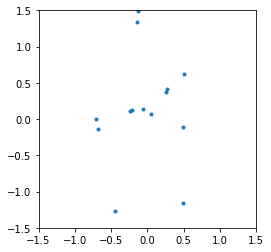

In [17]:
np_constellation = sess.run(constellation)
plt.plot(np.real(np_constellation),np.imag(np_constellation),'.')
plt.axis('square')
lim_ = 1.5
plt.xlim(-lim_,lim_)
plt.ylim(-lim_,lim_)

In [19]:
import claude.models.NLIN as nlin
# System parameters
qamParam = nlin.defaultParameters()
qamParam.nSpans = ssfParam.nSpans

aseNoisePower, chi, X, intraConstAdd, interConstAdd = nlin.calcConstants(qamParam)
powerSweep = np.arange(-8, 4, 0.1)

# QAM
qam_constellation = np.squeeze(tx.qammod(param.M))
qamParam.kur, qamParam.kur3 = nlin.calcKur(qam_constellation)

qamEffSNR = powerSweep - nlin.calcNLIN(qamParam, powerSweep, aseNoisePower, chi, X, intraConstAdd, interConstAdd)

# learned constellation
aeNlinParam = qamParam
aeNlinParam.kur, aeNlinParam.kur3 = nlin.calcKur(np_constellation)

aeEffSNR = powerSweep - nlin.calcNLIN(aeNlinParam, powerSweep, aseNoisePower, chi, X, intraConstAdd, interConstAdd)

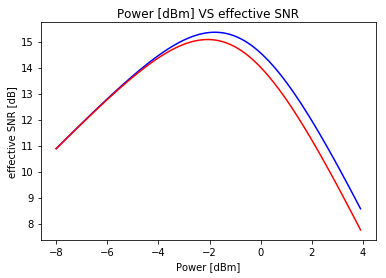

In [20]:
plt.plot(powerSweep, qamEffSNR, 'b')
plt.plot(powerSweep, aeEffSNR, 'r')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()